In [17]:
import numpy as np
import json
import subprocess
import os

In [26]:
# 自分自身をコピーして保存しておく ファイルを保存してから実行すること

import shutil
import datetime

t_delta = datetime.timedelta(hours=9)
JST = datetime.timezone(t_delta, 'JST')
now = datetime.datetime.now(JST)
d = now.strftime('%Y-%m-%d_%H-%M-%S')


if not os.path.exists('./reports'):
    os.mkdir('reports')

shutil.copy2('stabilize_quality_reports.ipynb','./reports/stabilize_quality_reports_'+ d +'.ipynb')

'./reports/stabilize_quality_reports_2022-12-08_03-18-02.ipynb'

In [19]:
# パラメータの定義
sync_period = 30
sync_frame_length = 999
dir = '/media/psf/Home/Dropbox/Mac/Documents/vgdataset/'
paths = {'C0003.MP4':'2019-04-03_07.27.36.json'}

In [20]:
import glob
import os
def cleanUp(video_path = None):
    csv_list = glob.glob("../build/*.csv")
    # print(file_list)
    for f in csv_list:
        os.remove(f)
        print('Removed:',f)

    json_list = glob.glob("../build/*.json",recursive=False)
    for f in json_list:
        if f != "../build/compile_commands.json":
            print('Removed:',f)
            os.remove(f)
    
    if video_path is not None:
        # SyncTable消す
        # 角速度消す
        # 特徴点は取っておく
        dir_name = os.path.dirname(video_path)
        base_name = os.path.splitext(os.path.basename(video_path))[0]
        sync_table_json = os.path.join(dir_name,base_name)+'_st.json'
        angular_velocity_json = os.path.join(dir_name,base_name)+'.json'
        # os.remove(os.path.join(dir_name,base_name)+'_st.json')
        if os.path.isfile(sync_table_json):
            print(sync_table_json)
            os.remove(sync_table_json)
        if os.path.isfile(angular_velocity_json):
            print(angular_velocity_json)
            os.remove(angular_velocity_json)


In [21]:
cleanUp('/home/parallels/vgdataset/C0003.MP4')

Removed: ../build/latest_measured_angular_velocity_resampled.csv
Removed: ../build/latest_warped_estimated_angular_velocity.csv
Removed: ../build/latest_sync_table.csv
Removed: ../build/2022-12-08_03-16-23_sync_table.csv
Removed: ../build/2022-12-08_03-16-28_filter_coefficients.csv
Removed: ../build/latest_filter_coefficients.csv
Removed: ../build/latest_correlation_coefficients.csv
Removed: ../build/latest_particial_estimated_angular_velocity.csv
Removed: ../build/latest_estimated_angular_velocity.csv
Removed: ../build/2022-12-08_03-16-18_estimated_angular_velocity.csv
Removed: ../build/timestamp_2022-12-08_03-16-30_warped_estimated_angular_velocity.csv
/home/parallels/vgdataset/C0003_st.json


In [22]:
def exec_vg(path,record,offset=None):
    if offset is None:
        cmd = './pixelwise_stabilizer -i ' + path + ' -c ILCE-6500 -l SEL1670Z -j ' + record + ' -z 1.3 -n -a -p ' + str(sync_period) + ' -s ' + str(sync_frame_length)
    else:
        cmd = './pixelwise_stabilizer -i ' + path + ' -c ILCE-6500 -l SEL1670Z -j ' + record + ' -z 1.3 -n -a -p ' + str(sync_period) + ' -s ' + str(sync_frame_length) + ' -x frame_offset_' + format(offset,'1.4f') + '.json'
    
    res = None
    try:
        print('cmd:',cmd)
        res = subprocess.check_call(cmd.split(),cwd="../build/")
    except:
        print("Error.")
    print(res)

In [23]:

from cProfile import label
import csv
import matplotlib.pyplot as plt

def openCSV(path):
    with open(path, 'r') as f:
        reader = csv.reader(f)
        header = next(reader)  # ヘッダー行を読み飛ばし

        data = []
        for row in reader:
            data.append(row)

    legends = [i for i in header]
    data = [[float(i) for i in row] for row in data]  # 文字列を数値に変換

    # X軸に時間を、Y軸にデータをセット
    eavf = [row[legends.index('Estimated angular velocity frame')] for row in data]
    mavf = [row[legends.index('Measured angular velocity frame')] for row in data]
    a = [row[legends.index('a-skew')] for row in data]
    b = [row[legends.index('b-offset')] for row in data]
    return eavf,mavf,a,b

In [24]:
def plotSync(x,y,labelx,labely,title):
    plt.figure(figsize=(10,6))
    plt.plot(x,y,'bo-')
    plt.xlabel(labelx)
    plt.ylabel(labely)          
    # plt.legend()
    plt.title(title)
    plt.grid()    
    plt.show()

cmd: ./pixelwise_stabilizer -i /media/psf/Home/Dropbox/Mac/Documents/vgdataset/C0003.MP4 -c ILCE-6500 -l SEL1670Z -j /media/psf/Home/Dropbox/Mac/Documents/vgdataset/2019-04-03_07.27.36.json -z 1.3 -n -a -p 10 -s 499
0
/media/psf/Home/Dropbox/Mac/Documents/vgdataset/C0003.MP4 /media/psf/Home/Dropbox/Mac/Documents/vgdataset/2019-04-03_07.27.36.json


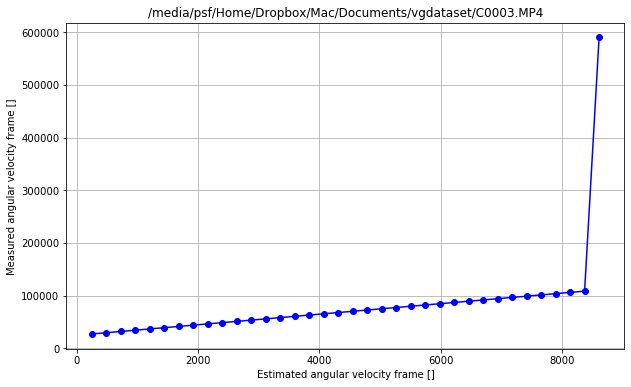

In [25]:
for p, r in paths.items():
    exec_vg(dir+p,dir+r)
    print(dir+p,dir+r)
    eavf,mavf,a,b = openCSV('../build/latest_sync_table.csv')
    plotSync(eavf,mavf,'Estimated angular velocity frame []','Measured angular velocity frame []',dir+p)
    

In [16]:
mavf

[29435.982576,
 36633.695098,
 43830.981194,
 51028.76779,
 58225.436269,
 65422.604247,
 72620.739191,
 79818.492754,
 87015.554626,
 94212.530412,
 101410.08878]

In [20]:
frame_offsets=np.linspace(-20.0,0.0,21)

for fo in frame_offsets:
    with open('../build/frame_offset_' + format(fo,'1.4f') + '.json', 'w') as f:
        obj={"frame_offset":fo, "path_prefix":format(fo,'1.4f')}
        json.dump(obj, f)

for p, r in paths.items():
    for fo in frame_offsets:
        exec_vg(dir+p,dir+r,fo)

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


In [32]:

from cProfile import label
import csv
import matplotlib.pyplot as plt

def openCSV(path):
    with open(path, 'r') as f:
        reader = csv.reader(f)
        header = next(reader)  # ヘッダー行を読み飛ばし

        data = []
        for row in reader:
            data.append(row)

    legends = [i for i in header]
    data = [[float(i) for i in row] for row in data]  # 文字列を数値に変換
    # data = [print(row) for row in data]  # 文字列を数値に変換
    # X軸に時間を、Y軸にデータをセット
    t = [row[legends.index('Frame')] for row in data]
    rxw = [row[legends.index('rx')] for row in data]
    ryw = [row[legends.index('ry')] for row in data]
    rzw = [row[legends.index('rz')] for row in data]
    return t, rxw, ryw, rzw

# 角加速度を計算する関数を定義。戻り値の配列の長さが元の配列より１短い事に注意。
import numpy as np

def getAngularAcceleration(angular_velocity, sampling_rate):
    return (np.array(angular_velocity)[1:]-np.array(angular_velocity)[:-1])*sampling_rate

def getAverageOfAbsAngularAcceleration(angular_velocity, sampling_rate):
    return np.average(np.abs(getAngularAcceleration(angular_velocity,sampling_rate)))

def getTime(angular_velocity,sampling_rate):
    return np.linspace(0,len(angular_velocity)-1,len(angular_velocity))/sampling_rate

def getA4(angular_velocity,sampling_rate, length):
    time = getTime(angular_velocity,sampling_rate)
    a4 = []
    time_average = []
    for i in range(0,len(angular_velocity),length):
        a4.append(getAverageOfAbsAngularAcceleration(angular_velocity[i:i+length],sampling_rate))
        time_average.append(np.average(time[i:i+length])) 
    return time_average, a4

def plotA4s(angular_velocitys,legends=None, sampling_rate=30., length=50,xlim=None,ylim=None):
    plt.figure(figsize=(12,6))

    if legends is not None:
        for av,lb in zip(angular_velocitys,legends):
            time_average, a4 = getA4(av,sampling_rate,length)
            plt.plot(time_average,a4,label=lb)
    else:
        for av in angular_velocitys:
            time_average, a4 = getA4(av,sampling_rate,length)
            plt.plot(time_average,a4)

    if xlim is not None:
        plt.xlim(xlim[0],xlim[1])
    if ylim is not None:
        plt.ylim(ylim[0],ylim[1])
    plt.xlabel('Time [second]')
    plt.ylabel('Average of Angular Acceleration [rad/s^2]')          
    plt.legend()
    plt.grid()




In [33]:
def plotRelativeA4s(angular_velocitys,original_angular_velocity,legends=None, sampling_rate=30., length=50,xlim=None,ylim=None):

    plt.figure(figsize=(10,6))

    if legends is not None:
        for av,oav,lb in zip(angular_velocitys,original_angular_velocity,legends):
            time_average, a4 = getA4(av,sampling_rate,length)
            time_average, oa4 = getA4(oav,sampling_rate,length)
            if lb == 'x_0.0000':
                plt.plot(time_average,np.array(a4)/(np.array(oa4)+0.001),'--',label=lb,)
            else:
                print(np.shape(time_average))
                print(np.shape(np.array(a4)))
                print(np.shape(np.array(oa4)))
                plt.plot(time_average,np.array(a4)/(np.array(oa4)+0.001),label=lb)
    else:
        for av,oav in zip(angular_velocitys,original_angular_velocity):
            time_average, a4 = getA4(av,sampling_rate,length)
            time_average, oa4 = getA4(oav,sampling_rate,length)
            plt.plot(time_average,np.array(a4)/(np.array(oa4)+0.001))
    


    if xlim is not None:
        plt.xlim(xlim[0],xlim[1])
    if ylim is not None:
        plt.ylim(ylim[0],ylim[1])
    plt.xlabel('Time [second]')
    plt.ylabel('Reduction ratio [ ]')     
    if legends is not None:     
        plt.legend()
    plt.grid()

(63, 9107) AAAA
(63, 9107)
(304,)
(304,)
(304,)
(304,)
(304,)
(304,)
(304,)
(304,)
(304,)
(304,)
(304,)
(304,)
(304,)
(304,)
(304,)
(304,)
(304,)
(304,)
(304,)
(304,)
(304,)
(304,)
(304,)
(304,)
(304,)
(304,)
(304,)
(304,)
(304,)
(304,)
(304,)
(304,)
(304,)
(304,)
(304,)
(304,)
(304,)
(304,)
(304,)
(304,)
(304,)
(304,)
(304,)
(304,)
(304,)
(304,)
(304,)
(304,)
(304,)
(304,)
(304,)
(304,)
(304,)
(304,)
(304,)
(304,)
(304,)
(304,)
(304,)
(304,)


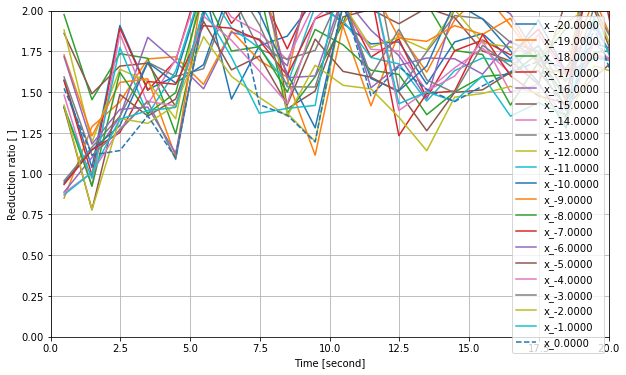

In [34]:
# 時系列方向のreduction ratioをまず表示。offset = 0のデータで良い。
# frame_offsets=np.linspace(-4.0,0.0,21)
legend = []
datas = None
for fo in frame_offsets:
    numstr = format(fo,'1.4f')
    # CSVを開く
    data = openCSV('../build/' + numstr + '_warped_estimated_angular_velocity.csv')
    # legendを書く
    legend.append('x_' + numstr)
    # legend.append('y_' + numstr)
    # legend.append('z_' + numstr)
    
    # データを結合する
    if datas is None:
        datas = data[1:] # X axis only
    else:
        datas = np.append(datas,data[1:],axis=0) # X axis only

# legend = []
original_datas = None
for fo in frame_offsets:
    numstr = format(fo,'1.4f')
    # CSVを開く
    data = openCSV('../build/latest_estimated_angular_velocity.csv')
    # legendを書く
    # legend.append('x_' + numstr)
    # legend.append('y_' + numstr)
    # legend.append('z_' + numstr)
    

    # データを結合する
    if original_datas is None:
        original_datas = data[1:]
    else:
        original_datas = np.append(original_datas,data[1:],axis=0)

print(np.shape(datas),'AAAA')
print(np.shape(original_datas))
plotRelativeA4s(datas,original_datas, sampling_rate=30.,legends=legend,length=30,xlim=[0,20],ylim=[0,2])

(304,)
(304,)
(304,)
(304,)
(304,)
(304,)
(304,)
(304,)
(304,)
(304,)
(304,)
(304,)
(304,)
(304,)
(304,)
(304,)
(304,)
(304,)
(304,)
(304,)
(304,)
(304,)
(304,)
(304,)
(304,)
(304,)
(304,)
(304,)
(304,)
(304,)
(304,)
(304,)
(304,)
(304,)
(304,)
(304,)
(304,)
(304,)
(304,)
(304,)
(304,)
(304,)
(304,)
(304,)
(304,)
(304,)
(304,)
(304,)
(304,)
(304,)
(304,)
(304,)
(304,)
(304,)
(304,)
(304,)
(304,)
(304,)
(304,)
(304,)


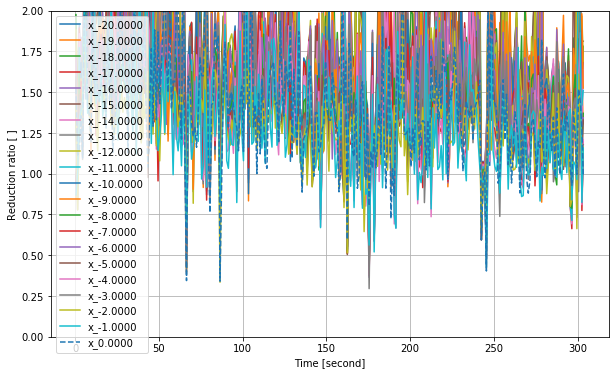

In [35]:
plotRelativeA4s(datas,original_datas, sampling_rate=30.,legends=legend,length=30,ylim=[0,2])

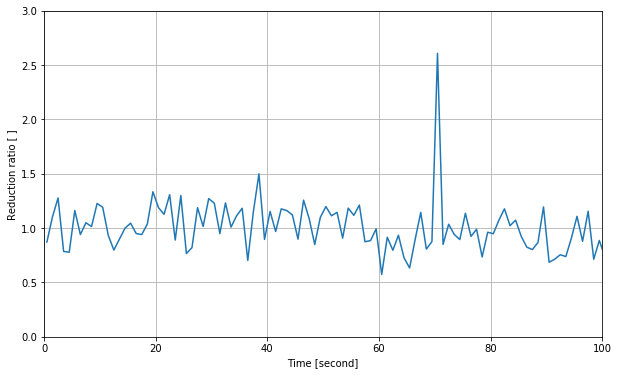

In [36]:
plotRelativeA4s([datas[int(datas.shape[0]/2)]],[original_datas[int(original_datas.shape[0]/2)]], sampling_rate=30.,length=30,xlim=[0,100],ylim=[0,3])

In [37]:
def getAverageRelativeA4s(angular_velocitys,original_angular_velocity,frame_offset,legends=None, sampling_rate=30., length=50,xlim=None,ylim=None):

    ratio = []

    if legends is not None:
        for av,oav,lb in zip(angular_velocitys,original_angular_velocity,legends):
            time_average, a4 = getA4(av,sampling_rate,length)
            time_average, oa4 = getA4(oav,sampling_rate,length)
            # plt.plot(time_average,np.array(a4)/(np.array(oa4)+0.001),label=lb)
            ratio.append(np.average(a4)/np.average(oa4))
    else:
        for av,oav in zip(angular_velocitys,original_angular_velocity):
            time_average, a4 = getA4(av,sampling_rate,length)
            time_average, oa4 = getA4(oav,sampling_rate,length)
            # plt.plot(time_average,np.array(a4)/(np.array(oa4)+0.001))
            ratio.append(np.average(a4)/np.average(oa4))
        


    rsratio = np.reshape(np.array(ratio),(int(len(ratio)/3),3))

    
    return rsratio

In [38]:
min_red_tatio = []
ave_frame = []
# length = 200
length = 100
for i in range(0,len(datas[0])-1-length,length):
    red_ratio = getAverageRelativeA4s(datas[:,i:i+length],original_datas[:,i:i+length], frame_offset=frame_offsets, sampling_rate=30.,length=20)
    print(min(red_ratio[:,0]))
    if min(red_ratio[:,0]) is np.NaN:
        print(red_ratio)
    x_axis_ratio = red_ratio[:,0]
    x_axis_min_value_index = np.argmin(x_axis_ratio)
    
    min_red_tatio.append(frame_offsets[x_axis_min_value_index])
    ave_frame.append((i + length/2))

0.6712547872561844
0.12957734606577048
0.1292429165557001
0.1171184441650874
0.10536925326551942
0.11370010423357073
0.10792007781213755
0.09682334730481974
0.08994271971493088
0.10814618729235405
0.09133266803322904
0.08159090833863149
0.0851885160724911
0.0904731780546347
0.09691699837657079
0.0924827397011116
0.10291833099118818
0.07911166032748035
0.0968383245142951
0.1407375570656264
0.10852807207478532
0.2012550419382087
0.18491925696156944
0.5468686703736706
0.26199796745683357
0.21389771905053961
0.1878970633604005
0.12514357484266508
0.11737412457224725
0.11555984643644807
0.15705670555406628
0.0954413320693673
0.10127336677295058
0.1004288280337187
0.10586030857749666
0.1245987503366317
0.11073961141924112
0.09918410196731492
0.09396084591392843
0.08182601418324789
0.9984615152941779
0.30567662577944715
0.6944789386473703
0.10427091313856172
0.3794878193277018
0.08794780944204049
0.11474112388499187
0.6183902335290704
0.40563364849919414
0.17671614315889297
0.1213867766706781

<ipython-input-39-5da43481ed63>:4: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  a,b = np.linalg.lstsq(A,min_red_tatio)[0]


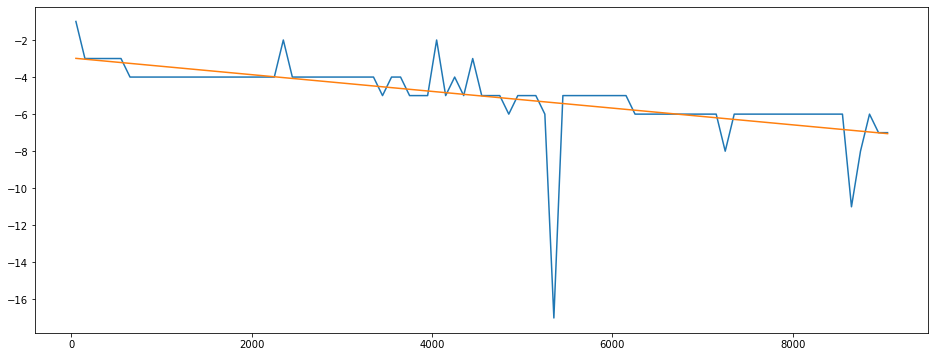

In [39]:
# 角加速度が最小となる時刻オフセット
A = np.array([ave_frame,np.ones(len(ave_frame))])
A = A.T
a,b = np.linalg.lstsq(A,min_red_tatio)[0]

plt.figure(figsize=(16,6))
plt.plot(ave_frame,min_red_tatio)
plt.plot(ave_frame,(a*np.array(ave_frame)+b))

In [40]:
import pprint

In [41]:
def plotAverageRelativeA4sNew(angular_velocitys,original_angular_velocitys,frame_offset,legends=None, sampling_rate=30., length=50,xlim=None,ylim=None):
    
    plt.figure(figsize=(10,6))

    for i in range(0,len(angular_velocitys[0])-1,length):
        # print(i,i+length)
        div_angular_velocity = angular_velocitys[:,i:i+length]
        div_original_angular_velocity = original_angular_velocitys[:,i:i+length]
        
        ratio = []

        if legends is not None:
            for av,oav,lb in zip(div_angular_velocity,div_original_angular_velocity,legends):

                time_average, a4 = getA4(av,sampling_rate,length)
                time_average, oa4 = getA4(oav,sampling_rate,length)
                # print(a4)
                # print(oa4)
                ratio.append(np.average(a4)/(np.average(oa4)+0.0001))
            if i < 10*length:
                plt.plot(frame_offset,ratio,label=str(i))
            elif i < 20*length:
                plt.plot(frame_offset,ratio,'--',label=str(i))
            elif i < 30*length:
                plt.plot(frame_offset,ratio,'+',label=str(i))
            else:
                plt.plot(frame_offset,ratio,'o',label=str(i))
        else:
            for av,oav in zip(div_angular_velocity,div_original_angular_velocity):
                time_average, a4 = getA4(av,sampling_rate,length)
                time_average, oa4 = getA4(oav,sampling_rate,length)
                ratio.append(np.average(a4)/(np.average(oa4)+0.0001))
            plt.plot(frame_offset,ratio)

        # print('ratio',ratio)
        # rsratio = np.reshape(np.array(ratio),(int(len(ratio)/3),3))

        # print('frame_offset',frame_offset)
        # print('rsratio[:,0]',rsratio[:,0])
        # plt.plot(frame_offset,rsratio[:,0])
        
        

    if xlim is not None:
        plt.xlim(xlim[0],xlim[1])
    if ylim is not None:
        plt.ylim(ylim[0],ylim[1])
    plt.xlabel('Frame [ ]')
    plt.ylabel('Reduction ratio [ ]')   
    if legends is not None:          
        plt.legend()
    plt.grid()
    plt.show()


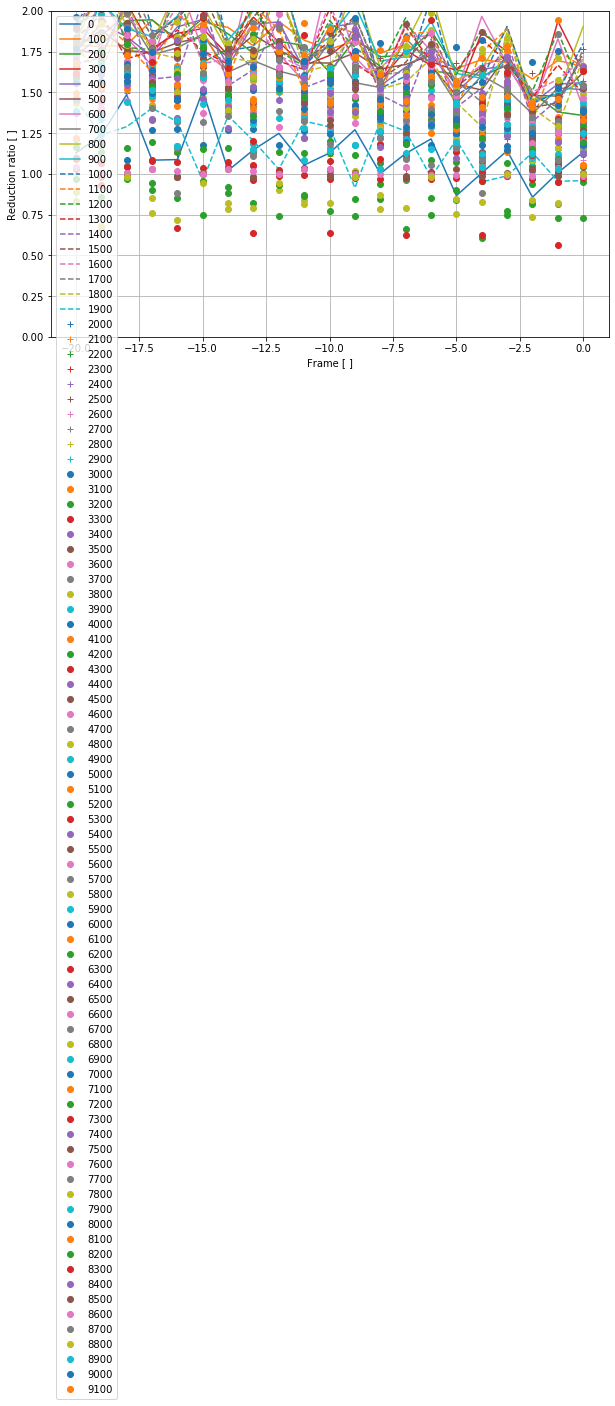

In [42]:
plotAverageRelativeA4sNew(datas,original_datas, frame_offsets, sampling_rate=30.,legends=legend,length=100,ylim=[0,2])